In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import nrrd
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
# corta imagem 2d, de modo a eliminar pixels pretos, deixando só um retângulo ajustado ao cérebro
def crop_black_slices_2d(data):
        if np.count_nonzero(data) == 0:
                return [], []
        
        right, left, top, down = data.shape[1]-1, 0, 0, data.shape[0]-1

        while np.count_nonzero(data[:, left]) == 0: # anda com limite esquerdo pra direita até achar um pixel não preto
                left += 1

        while np.count_nonzero(data[:, right]) == 0: # anda com limite direito pra esquerda até achar um pixel não preto
                right -= 1

        while np.count_nonzero(data[top, :]) == 0: # anda com limite inferior pra cima até achar um pixel não preto
                down += 1

        while np.count_nonzero(data[down, :]) == 0: # anda com limite superior pra baixo até achar um pixel não preto
                top -= 1

        data_2d = data[down:top, left:right]

        return data_2d, [left, right, top, down]

# cria o grid, encaixando os quadrados até o eixo central
def create_grid_half_vertical(data, size, overlap, threshold):
    grid = []
    width = data.shape[1]//2
    
    for i in range(0, (data.shape[0] - size + 1), size):
        for j in range(width, 0, -overlap):
            if j - size < 0:  # Garante que o quadrado não atravesse o centro
                break
            if np.count_nonzero(data[i:i + size - 1, j - size - 1:j]) > data[i:i + size - 1, j - size - 1:j].size * threshold:
                grid.append([i, i + size - 1, j - size - 1, j])  # [y1, y2, x1, x2]
    
    return grid

# cria o grid, encaixando os quadrados até o eixo central
def create_grid_half_vertical_flexible(data, size, overlap, threshold):
    grid = []
    width = data.shape[1]//2
    
    for i in range(0, (data.shape[0] - size + 1), size):
        for j in range(width, 0, -overlap):
            if j - size < 0:  # Garante que o quadrado não atravesse o centro
                break
            if np.count_nonzero(data[i:i + size - 1, j - size - 1:j]) > data[i:i + size - 1, j - size - 1:j].size * threshold:
                grid.append([i, i + size - 1, j - size - 1, j])  # [y1, y2, x1, x2]
    
    return grid

# alinha o grid das pontas até encontrar o cérebro, evitando recortes puramente pretos
# implementar: descarte de fatias com poucos pixels, tratamento de casos onde um quadradinho nunca acha cérebro, então anda até passar do limite do vetor e achar erro
def move_grid(data, grid):
    new_grid = []
    width = data.shape[1]//2

    for rect in grid:
        y1, y2, x1, x2 = rect[0], rect[1], rect[2], rect[3]
        
        # Verifica se o quadrado contém apenas pixels pretos
        if np.count_nonzero(data[y1:y2+1, x1:x2+1]) < 0:
            break

        # Movimenta o grid para evitar regiões completamente pretas
        while y2 < data.shape[0] - 1:
            if np.count_nonzero(data[y1, x1:x2+1]) > 0:  # Se há conteúdo, sai do loop
                break
            y1 += 1
            y2 += 1

        while y1 > 0:
            if np.count_nonzero(data[y2, x1:x2+1]) > 0:  # Se há conteúdo, sai do loop
                break
            y1 -= 1
            y2 -= 1

        while x1 > 0 and  x2 < width - 1:
            if np.count_nonzero(data[y1:y2+1, x1]) > 0:  # Se há conteúdo, sai do loop
                break
            x1 += 1
            x2 += 1

        while x1 > 0 and x2 < width:
            if np.count_nonzero(data[y1:y2+1, x2]) > 0:  # Se há conteúdo, sai do loop
                break
            x1 -= 1
            x2 -= 1

        # Após movimentar, verifica se o quadrado contém pixels diferentes de preto
        if (
            0 <= y1 < data.shape[0]
            and 0 <= y2 < data.shape[0]
            and 0 <= x1 < data.shape[1]
            and 0 <= x2 < data.shape[1]
            and np.count_nonzero(data[y1:y2+1, x1:x2+1]) >= data[y1:y2+1, x1:x2+1].size * 0.4
        ):
            new_grid.append([y1, y2, x1, x2])

    return new_grid


# espeçha o grid
# a ideia é a funcao create_grid_half criar metade do grid, e a outra metade ser espelhada com essa função
def mirror_grid_vertical(grid, data):
    shape = data.shape  # Obtém o formato da imagem (altura, largura)
    mirror = []  # Lista para armazenar o grid espelhado

    for rect in grid:
        # Extrai as coordenadas do retângulo original
        y1, y2, x1, x2 = rect

        # Calcula as novas coordenadas espelhadas em relação ao eixo vertical (colunas)
        x3 = shape[1] - x2  # Posição inicial do espelhado
        x4 = shape[1] - x1  # Posição final do espelhado
        y3, y4 = y1, y2  # Linhas permanecem iguais

        # Garante que as novas coordenadas estão na ordem correta
        if x3 > x4:
            x3, x4 = x4, x3

        # Adiciona o retângulo espelhado
        mirror.append([y3, y4, x3, x4])

    return mirror

def create_full_grid(data, size, overlap, threshold):
        moved_grid, mirror_grid = [], []
        
        if np.count_nonzero(data) != 0 :
        
            grid_2d = create_grid_half_vertical(data, size, overlap, threshold)
            moved_grid = move_grid(data, grid_2d)
            mirror_grid = mirror_grid_vertical(moved_grid, data)

        return moved_grid, mirror_grid

def plot_grid(data, grid):
    if (data.size != 0 and len(grid) != 0):
        plt.imshow(data, cmap='gray')

        for rect in (grid):
        
            y1, y2, x1, x2 = rect[0], rect[1], rect[2], rect[3]

            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='red', facecolor='none'))

        plt.show()

In [11]:
# informações pra analisar dados
imagens = "Patients_Displasya"
mascara = "Mascaras"
coordinates_path = f"Coordenadas_grid"

total_label1 = []
excluded_patients = ["sub-54K08", "sub-87G01", "sub-89A03", "sub-90K10"]

for img, mask in zip([f for f in os.listdir(imagens) if f.endswith(('.nii', '.nii.gz'))], [f for f in os.listdir(mascara) if f.endswith(('.nrrd', '.nii', '.nii.gz'))]):    
    if img.split('_')[0] in excluded_patients:
        continue
    data = nib.load(os.path.join(imagens, img)).get_fdata()
    lesion_data, _ = nrrd.read(os.path.join(mascara, mask))
    
    data = np.rot90(data, k=1)  # Rotaciona a imagem 90 graus
    lesion_data = np.rot90(lesion_data, k=1)  # Rotaciona a máscara 90 graus
    
    # Verifica o formato das imagens
    print(data[2].shape)
    print(lesion_data[2].shape)

    # Contador para acompanhar quantas fatias foram processadas
    processed_slices = 0

    # Diretório de saída para salvar as fatias
    output_dir_left = os.path.join(f"Novo_Contralateral/{img.split('_')[0]}", "left")
    output_dir_right = os.path.join(f"Novo_Contralateral/{img.split('_')[0]}", "right")
    output_dir_lesion_left = os.path.join(f"Novo_Contralateral/{mask.split(' ')[0]}", "lesion_left")
    output_dir_lesion_right = os.path.join(f"Novo_Contralateral/{mask.split(' ')[0]}", "lesion_right")
    os.makedirs(output_dir_left, exist_ok=True)
    os.makedirs(output_dir_right, exist_ok=True)
    os.makedirs(output_dir_lesion_left, exist_ok=True)
    os.makedirs(output_dir_lesion_right, exist_ok=True)

    coordinates_path = f"Coordenadas_grid/{img.split('_')[0]}"
    os.makedirs(coordinates_path, exist_ok=True)
    
    # Loop para cada fatia axial
    for slice_idx in range(data.shape[2]):
        # Pega a lesão da fatia axial atual
        lesion_slice_data = lesion_data[:, :, slice_idx]
        lesion_slice_data = np.where(lesion_slice_data>0.9, 1, 0)
        
        # Pega a fatia axial atual
        #slice_data = data[16:233-17, 18:197-19, slice_idx]
        slice_data = data[:, :, slice_idx]
        
        # Total de pixels na subimagem
        total_pixels = slice_data.size
        # Número de pixels não-preto
        non_zero_pixels = np.count_nonzero(slice_data)
        # Proporção de pixels não-preto
        non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
        
        if non_black_ratio >= 0.04:
            adjusted_grid_img, mirrored_grid = create_full_grid(slice_data, 40, 35, 0.01)
            
            # Garante que left e right sejam tratados separadamente
            left_grid = adjusted_grid_img
            right_grid = mirrored_grid

            # Separar subimagens em lados esquerdo e direito
            left_subimages = []
            right_subimages = []

            # Para o lado esquerdo
            for idx, rect in enumerate(left_grid):
                y1, y2, x1, x2 = rect
                subimage = slice_data[y1:y2+1, x1:x2+1]
                position = f"left_{idx + 1:03}"
                left_subimages.append((subimage, position))

            # Para o lado direito
            for idx, rect in enumerate(right_grid):
                y1, y2, x1, x2 = rect
                subimage = slice_data[y1:y2+1, x1:x2+1]
                position = f"right_{idx + 1:03}"
                right_subimages.append((subimage, position))

            if len(left_subimages) == 0 or len(right_subimages) == 0 :
                print(f"{img.split('_')[0]} - left:{len(left_subimages)} | right:{len(right_subimages)}")
                continue
            
            output_dir_left_slice = os.path.join(output_dir_left, f"Slice{slice_idx:03}/")
            output_dir_right_slice = os.path.join(output_dir_right, f"Slice{slice_idx:03}/")

            os.makedirs(output_dir_left_slice, exist_ok=True)
            os.makedirs(output_dir_right_slice, exist_ok=True)
            
            processed_slices += 1
            
            # Salvar subimagens para cada lado
            for subimage, position in left_subimages:
                output_path = os.path.join(output_dir_left_slice, f"{position}.nii.gz")
                subimage_nii = nib.Nifti1Image(subimage, affine=np.eye(4))
                nib.save(subimage_nii, output_path)

            for subimage, position in right_subimages:
                output_path = os.path.join(output_dir_right_slice, f"{position}.nii.gz")
                subimage_nii = nib.Nifti1Image(subimage, affine=np.eye(4))
                nib.save(subimage_nii, output_path)

            # Aplicar o mesmo grid para lesion_slice_data
            left_subimages_lesion = []
            right_subimages_lesion = []
            
            # Para o lado esquerdo
            for idx, rect in enumerate(left_grid):
                y1, y2, x1, x2 = rect
                subimage_lesion = lesion_slice_data[y1:y2+1, x1:x2+1]
                position = f"left_{idx + 1:03}"
                left_subimages_lesion.append((subimage_lesion, position))

            # Para o lado direito
            for idx, rect in enumerate(right_grid):
                y1, y2, x1, x2 = rect
                subimage_lesion = lesion_slice_data[y1:y2+1, x1:x2+1]
                position = f"right_{idx + 1:03}"
                right_subimages_lesion.append((subimage_lesion, position))
                
            output_dir_lesion_left_slice = os.path.join(output_dir_lesion_left, f"Slice_{slice_idx:03}")
            output_dir_lesion_right_slice = os.path.join(output_dir_lesion_right, f"Slice_{slice_idx:03}")
            
            os.makedirs(output_dir_lesion_left_slice, exist_ok=True)
            os.makedirs(output_dir_lesion_right_slice, exist_ok=True)
            
            # Salvar subimagens para cada lado
            for subimage, position in left_subimages_lesion:
                output_path = os.path.join(output_dir_lesion_left_slice, f"{position}.nii.gz")
                subimage_nii = nib.Nifti1Image(subimage, affine=np.eye(4), dtype=np.int64)
                nib.save(subimage_nii, output_path)

            for subimage, position in right_subimages_lesion:
                output_path = os.path.join(output_dir_lesion_right_slice, f"{position}.nii.gz")
                subimage_nii = nib.Nifti1Image(subimage, affine=np.eye(4), dtype=np.int64)
                nib.save(subimage_nii, output_path)
            
            coordinates_path = f"Coordenadas_grid/{img.split('_')[0]}/Slice_{slice_idx:03}.txt"
            # Escreve as coordenadas no arquivo TXT
            with open(coordinates_path, 'w') as f:
                for rect in (left_grid+right_grid):
                    y1, y2, x1, x2 = rect
                    f.write(f"{y1},{y2},{x1},{x2}\n")

    print(f"Paciente {img.split('_')[0]} recortado com sucesso!")

(197, 189)
(197, 189)
Paciente sub-00H10 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-02A13 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-03C08 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-06C09 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-14F04 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-16E03 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-16G09 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-16I12 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-19F09 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-19G04 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-22F14 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-25B08 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-26B09 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-29D03 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-31F07 recortado com sucesso!
(197, 189)
(197, 189)
sub-34J06 - left:0

(233, 197, 189)
233
197
189


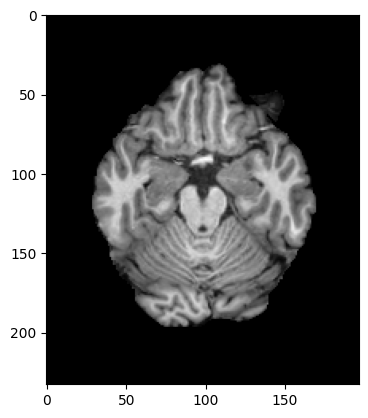

In [5]:
# informações pra analisar dados

img_path = 'Patients_Displasya/sub-06C09_ses-01_acq-vbm_desc-reg_desc-biascorr_desc-brainext_T1w.nii.gz'
z_idx = 50
img = nib.load(img_path)
data_3d = img.get_fdata()
data_3d = np.rot90(data_3d, k=1)  # Rotaciona a imagem 90 graus


print(data_3d.shape)
print(data_3d.shape[0])
print(data_3d.shape[1])
print(data_3d.shape[2])

plt.imshow(data_3d[:, :, z_idx], cmap='gray')
plt.show()

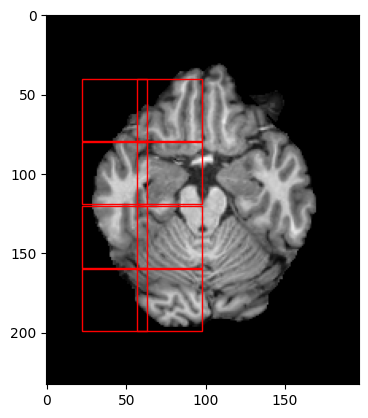

In [6]:
#img_test = data_3d[16:233-17, 18:197-19, z_idx]  # Para deixar com dimensões (160, 200)
img_test = data_3d[:, :, z_idx]  # dimensões originais
grid = []

grid = create_grid_half_vertical(img_test, 40, 35, 0.1)  # Substituir pela função para grid vertical

plot_grid(img_test, grid)

In [7]:
for item in grid:
    print(item)

[40, 79, 57, 98]
[40, 79, 22, 63]
[80, 119, 57, 98]
[80, 119, 22, 63]
[120, 159, 57, 98]
[120, 159, 22, 63]
[160, 199, 57, 98]
[160, 199, 22, 63]


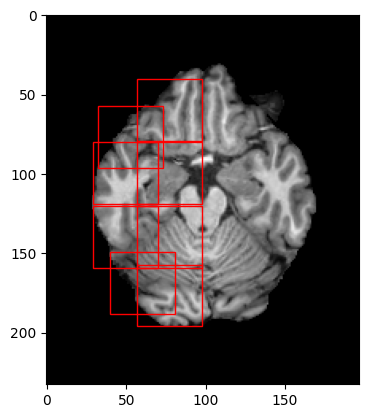

In [8]:
plt.imshow(img_test, cmap='gray')

adjusted_grid = move_grid(img_test, grid) # move cada quadradinho para encaixar no cérebro, minimizando espaços pretos

plot_grid(img_test, adjusted_grid)

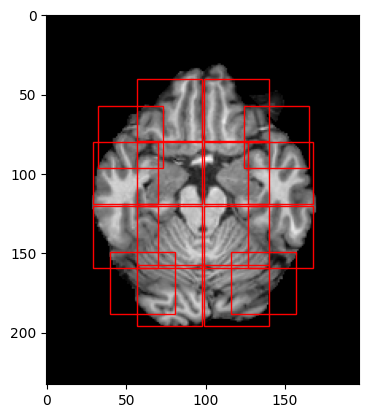

In [9]:
mirror_adjusted_grid = mirror_grid_vertical(adjusted_grid, img_test)

plot_grid(img_test, adjusted_grid+mirror_adjusted_grid)

In [ ]:
for item in (adjusted_grid+mirror_adjusted_grid):
    print(item)

In [ ]:
patient1 = 'sub-72K02_ses-01_acq-mpr_run-01_desc-reg_desc-biascorr_desc-brainext_T1w.nii.gz'
patient2 = 'sub-86G08_ses-01_acq-posgado_desc-reg_desc-biascorr_desc-brainext_T1w.nii.gz'

for patient in os.listdir('Patients_Displasya'):
    path = os.path.join('Patients_Displasya', patient)
    data_3d = nib.load(path).get_fdata()
    data_3d = np.rot90(data_3d, k=3)  # Rotaciona a imagem 90 graus

    for z in range(0, data_3d.shape[2]-1):
        data_2d = data_3d[:, :, z]
        
        moved, mirror = create_full_grid(data_2d, 40, 35, 0.1)

        full_grid = moved+mirror

        print(f"z={z} n_grid={len(mirror+moved)} paciente {patient}")

        plt.imshow(data_2d, cmap='gray')
        plt.title(f"z={z} n_grid={len(mirror+moved)} paciente {patient}")

        for rect in (moved+mirror):
        
            y1, y2, x1, x2 = rect[0], rect[1], rect[2], rect[3]

            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='red', facecolor='none'))

        plt.show()

In [ ]:
for z in range(0, data_3d.shape[2]-1):
        data_2d = data_3d[:, :, z]
        
        moved, mirror = create_full_grid(data_2d, 40, 35, 0.1)

        full_grid = moved+mirror

        if len(full_grid) != 0:

            plt.imshow(data_2d, cmap='gray')
            plt.title(f"z={z} n_grid={len(full_grid)}")

            for rect in (full_grid):
            
                y1, y2, x1, x2 = rect[0], rect[1], rect[2], rect[3]

                plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='red', facecolor='none'))

            plt.show()